In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch import nn, optim
import numpy as np


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean=0.5 and std=0.5
])

# Download and load the training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Download and load the test data
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example: Display the size of the training set
print(f"Number of training samples: {len(train_dataset)}")


Number of training samples: 60000


In [3]:

print("Original labels (before noise):", train_dataset.targets[:10].tolist())

# Function to add label noise by shuffling labels
def add_label_noise(dataset, noise_fraction):
    """
    Adds label noise by shuffling labels for a fraction of the dataset.

    Args:
        dataset: A PyTorch dataset object (e.g., MNIST).
        noise_fraction: Fraction of data to corrupt (0 <= noise_fraction <= 1).

    Returns:
        The dataset with shuffled labels for the specified fraction.
    """
    # Total number of samples
    num_samples = len(dataset)
    
    # Number of labels to corrupt
    num_noisy_labels = int(noise_fraction * num_samples)
    
    # Get the indices to shuffle
    indices = np.random.choice(num_samples, num_noisy_labels, replace=False)
    
    # Shuffle the labels
    noisy_targets = dataset.targets.clone()  # Clone the targets to avoid modifying the original directly
    noisy_targets[indices] = torch.randint(0, 10, size=(num_noisy_labels,))  # Random labels in the range [0, 9]
    
    # Update the dataset's targets
    dataset.targets = noisy_targets
    return dataset



Original labels (before noise): [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [4]:
subset_size = 10000  # Use only 10,000 samples
train_dataset = add_label_noise(train_dataset, noise_fraction=0.2)
indices = np.random.choice(len(train_dataset), subset_size, replace=False)  # Randomly select indices
train_subset = Subset(train_dataset, indices)


# Create data loaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [17]:
class DeepNN(nn.Module):
    def __init__(self):
        super(DeepNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),  # First layer with 512 neurons
            nn.ReLU(),
            #nn.Dropout(0.3),       # Dropout for regularization
            nn.Linear(512, 256),   # Second layer with 256 neurons
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(256, 128),   # Third layer with 128 neurons
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(128, 64),    # Fourth layer with 64 neurons
            nn.ReLU(),
            nn.Linear(64, 10)      # Output layer for 10 classes
        )
    
    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        return self.model(x)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepNN().to(device)
criterion = nn.CrossEntropyLoss()

# Define optimizers
optimizers = {
    'SGD': optim.SGD(model.parameters(), lr=0.01, momentum=0),
    'Adam': optim.Adam(model.parameters(), lr=0.001),
    'RMSprop': optim.RMSprop(model.parameters(), lr=0.001)
}
# Dictionary to store test losses for each optimizer
training_losses = {opt_name: [] for opt_name in optimizers.keys()}
test_losses = {opt_name: [] for opt_name in optimizers.keys()}
test_accuracies = {opt_name: [] for opt_name in optimizers.keys()}

# Modified training function
def train_model(optimizer_name, optimizer, num_epochs=200):
    print(f"\nTraining with {optimizer_name}...")
    model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
    optimizer = optimizer
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accumulate metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Calculate training metrics
        train_accuracy = 100 * correct_train / total_train
        train_loss = running_loss / len(train_loader)
        training_losses[optimizer_name].append(train_loss)  # Record training loss
        
        # Evaluate the model on the test set
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        test_loss /= len(test_loader)
        test_accuracy = 100 * correct_test / total_test
        test_losses[optimizer_name].append(test_loss)  # Record test loss
        test_accuracies[optimizer_name].append(test_accuracy)  # Record test accuracy
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Training Loss: {train_loss:.4f}, "
              f"Training Accuracy: {train_accuracy:.2f}%, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Accuracy: {test_accuracy:.2f}%")

def evaluate_model():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Train the model with each optimizer
for opt_name, opt in optimizers.items():
    train_model(opt_name, opt)


Training with SGD...
Epoch [1/200], Training Loss: 2.3023, Training Accuracy: 13.17%, Test Loss: 2.2966, Test Accuracy: 24.97%
Epoch [2/200], Training Loss: 2.2927, Training Accuracy: 27.81%, Test Loss: 2.2824, Test Accuracy: 30.14%
Epoch [3/200], Training Loss: 2.2787, Training Accuracy: 23.82%, Test Loss: 2.2606, Test Accuracy: 25.40%
Epoch [4/200], Training Loss: 2.2557, Training Accuracy: 22.63%, Test Loss: 2.2202, Test Accuracy: 26.44%
Epoch [5/200], Training Loss: 2.2074, Training Accuracy: 26.07%, Test Loss: 2.1267, Test Accuracy: 31.85%
Epoch [6/200], Training Loss: 2.0951, Training Accuracy: 31.44%, Test Loss: 1.9106, Test Accuracy: 42.36%
Epoch [7/200], Training Loss: 1.8648, Training Accuracy: 43.62%, Test Loss: 1.4861, Test Accuracy: 57.99%
Epoch [8/200], Training Loss: 1.6105, Training Accuracy: 53.48%, Test Loss: 1.1723, Test Accuracy: 62.09%
Epoch [9/200], Training Loss: 1.4985, Training Accuracy: 58.95%, Test Loss: 1.0716, Test Accuracy: 71.78%
Epoch [10/200], Training

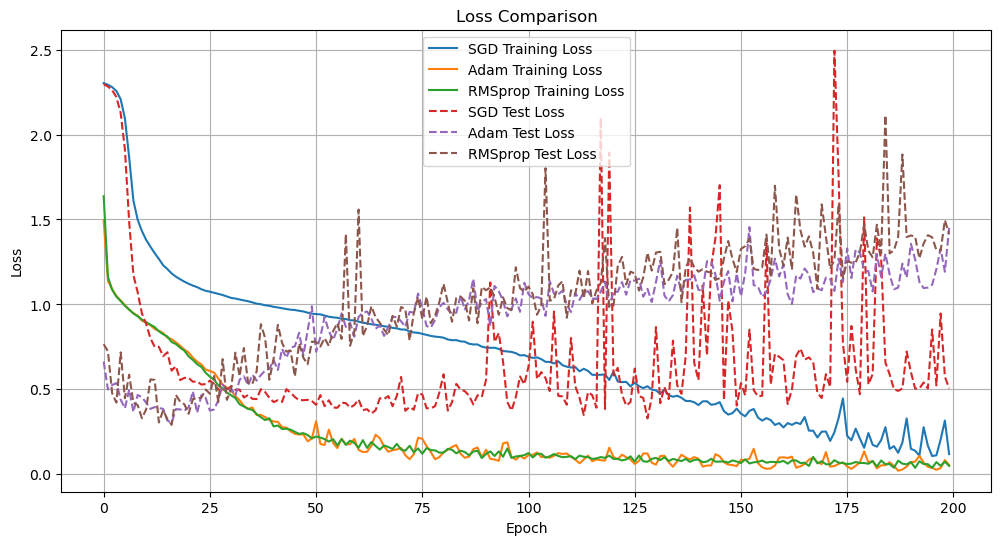

In [18]:
import matplotlib.pyplot as plt

# Plot training and test losses
plt.figure(figsize=(12, 6))


for opt_name, losses in training_losses.items():
    plt.plot(losses, label=f'{opt_name} Training Loss')
for opt_name, losses in test_losses.items():
    plt.plot(losses, linestyle='--', label=f'{opt_name} Test Loss')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)



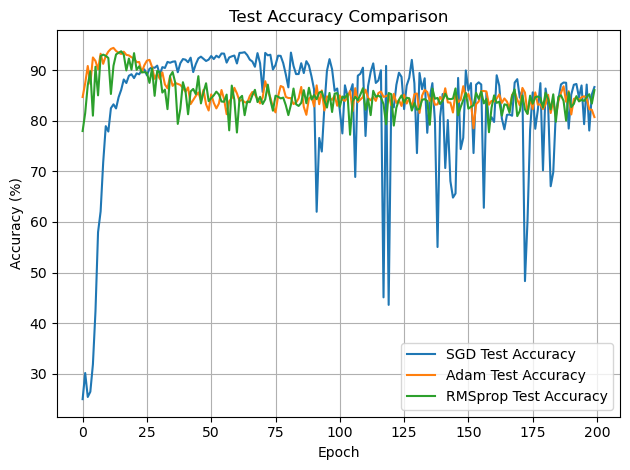

In [19]:

for opt_name, accs in test_accuracies.items():
    plt.plot(accs, label=f'{opt_name} Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
